<a href="https://colab.research.google.com/github/Saadi0014/Pima-Indians-Diabetes/blob/main/Pima_Diabetes_NN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pima Indians Diabetes Classification using Neural Network


## 1. Imports


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, classification_report
)

import tensorflow as tf
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping


## 2) Load dataset + quick view

In [5]:
import pandas as pd

url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
df = pd.read_csv(url)

print(df.shape)
df.head()


(768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [6]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


## 3) Visualization (required preprocessing visualization)

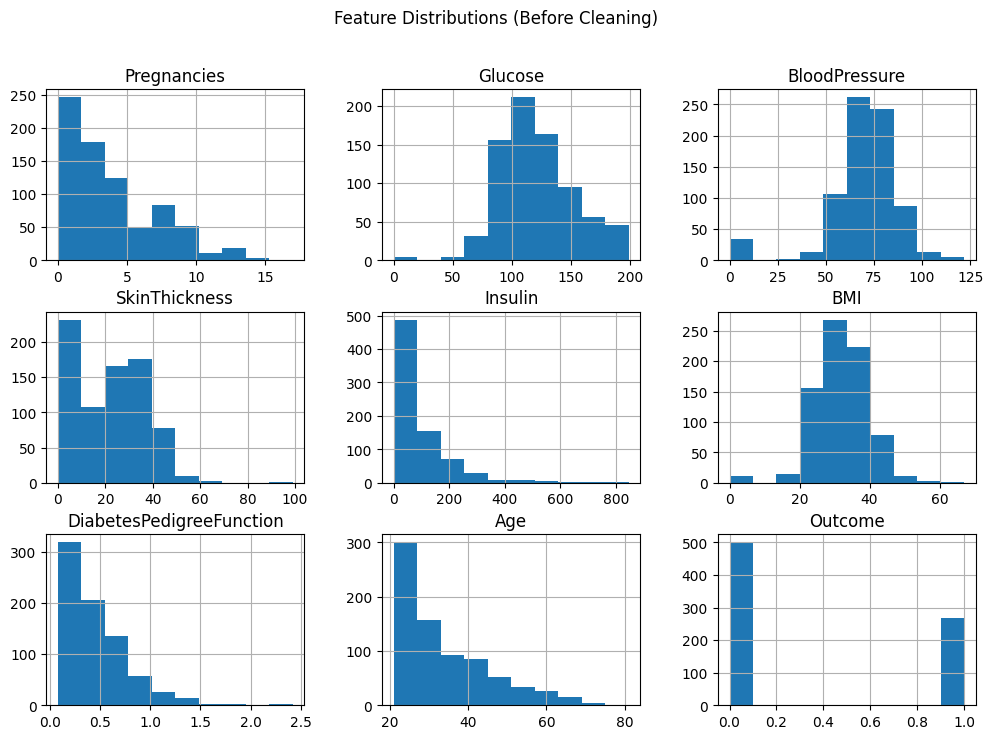

In [7]:
df.hist(figsize=(12,8))
plt.suptitle("Feature Distributions (Before Cleaning)")
plt.show()


## 4) Handle “missing values” statistically (zeros that shouldn’t be zero)

In [8]:
df_clean = df.copy()

zero_as_missing = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
df_clean[zero_as_missing] = df_clean[zero_as_missing].replace(0, np.nan)

print("Missing values after converting zeros to NaN:")
print(df_clean.isna().sum())
for col in zero_as_missing:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

print("Missing values after median imputation:")
print(df_clean.isna().sum())


Missing values after converting zeros to NaN:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64
Missing values after median imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


## 5) Outlier handling (IQR capping) + quick visualization

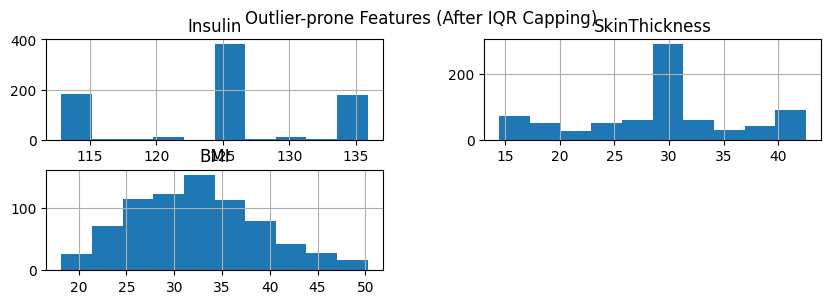

In [9]:
def iqr_cap(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower, upper)

outlier_cols = ["Insulin", "SkinThickness", "BMI"]
for col in outlier_cols:
    df_clean[col] = iqr_cap(df_clean[col])

# visualize after
df_clean[outlier_cols].hist(figsize=(10,3))
plt.suptitle("Outlier-prone Features (After IQR Capping)")
plt.show()


## 6) Add a derived feature (required)

In [10]:
df_clean["BMI_Age"] = df_clean["BMI"] / df_clean["Age"]


## 7) Prepare X/y and split (train/val/test)

In [11]:
X = df_clean.drop(columns=["Outcome"])
y = df_clean["Outcome"].astype(int)

# train 70%, temp 30%
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# val 15%, test 15%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

X_train.shape, X_val.shape, X_test.shape


((537, 9), (115, 9), (116, 9))

## 8) Standardization (required)

In [12]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test)


## 9) Build Neural Network (3+ hidden layers + special layers)

In [13]:
tf.random.set_seed(42)

model = tf.keras.Sequential([
    layers.Input(shape=(X_train_scaled.shape[1],)),

    layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.30),

    layers.Dense(32, activation="relu"),
    layers.Dropout(0.20),

    layers.Dense(16, activation="relu"),

    layers.Dense(1, activation="sigmoid")
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,265 (12.75 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 0 (0.00 B)

## 10) Compile + EarlyStopping + train

In [14]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=[
        "accuracy",
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        tf.keras.metrics.AUC(name="auc")
    ]
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True
)

history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - accuracy: 0.6374 - auc: 0.5606 - loss: 0.6478 - precision: 0.3659 - recall: 0.0593 - val_accuracy: 0.6609 - val_auc: 0.7488 - val_loss: 0.5881 - val_precision: 1.0000 - val_recall: 0.0250
Epoch 2/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6566 - auc: 0.6640 - loss: 0.6118 - precision: 0.5208 - recall: 0.0557 - val_accuracy: 0.6783 - val_auc: 0.7803 - val_loss: 0.5512 - val_precision: 0.6667 - val_recall: 0.1500
Epoch 3/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6978 - auc: 0.7543 - loss: 0.5669 - precision: 0.7745 - recall: 0.1799 - val_accuracy: 0.7130 - val_auc: 0.7907 - val_loss: 0.5298 - val_precision: 0.6842 - val_recall: 0.3250
Epoch 4/100
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7194 - auc: 0.7977 - loss: 0.5386 - precision: 0.7749 - recall: 0.2771 - val_accuracy: 0.7739 - val_auc: 0.7963 - val_loss: 0.5178 - val_precision: 0.7500 - val_recall: 0.5250
Epoch 5/100
17/17 ━━━━━━━━━━━━━━

## 11) Visualize performance (required)

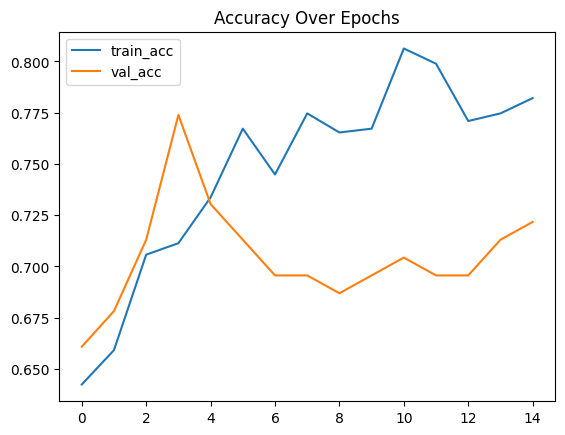

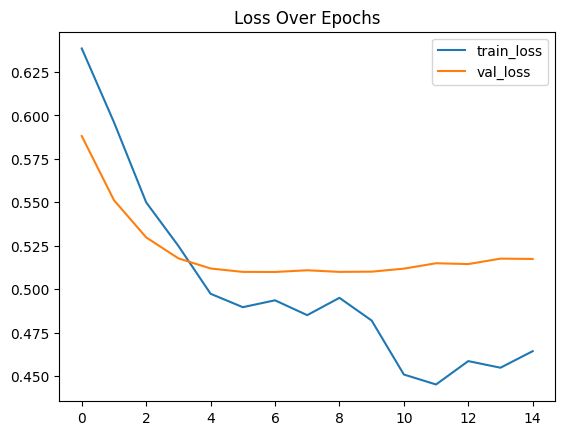

In [15]:
plt.figure()
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Over Epochs")
plt.legend()
plt.show()

plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss Over Epochs")
plt.legend()
plt.show()


## 12) Evaluate on val + test (metrics + confusion matrix)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Validation Results
Accuracy : 0.696
Precision: 0.564
Recall   : 0.550
AUC      : 0.800
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

Test Results
Accuracy : 0.741
Precision: 0.667
Recall   : 0.537
AUC      : 0.847


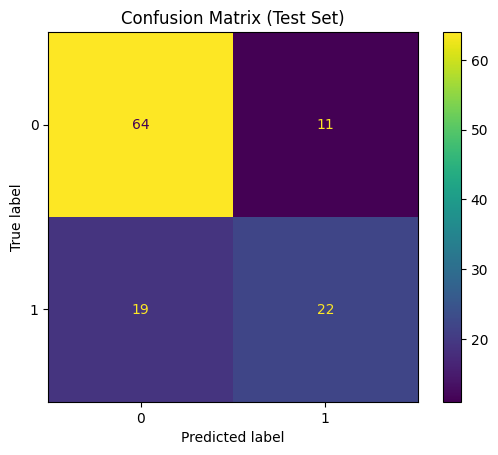


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.77      0.85      0.81        75
           1       0.67      0.54      0.59        41

    accuracy                           0.74       116
   macro avg       0.72      0.69      0.70       116
weighted avg       0.73      0.74      0.73       116



In [16]:
def evaluate_split(Xs, ys, name):
    probs = model.predict(Xs).ravel()
    preds = (probs >= 0.5).astype(int)

    acc = accuracy_score(ys, preds)
    prec = precision_score(ys, preds)
    rec = recall_score(ys, preds)
    auc = roc_auc_score(ys, probs)

    print(f"\n{name} Results")
    print(f"Accuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"AUC      : {auc:.3f}")
    return preds, probs

val_preds, val_probs = evaluate_split(X_val_scaled, y_val, "Validation")
test_preds, test_probs = evaluate_split(X_test_scaled, y_test, "Test")
cm = confusion_matrix(y_test, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix (Test Set)")
plt.show()

print("\nClassification Report (Test):")
print(classification_report(y_test, test_preds))
